<a href="https://colab.research.google.com/github/simonsny/image_background_removal/blob/dev_simon/modnet_alpha_matte_simon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
from google.colab import files

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/content
Cloning into 'MODNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 213 (delta 1), reused 0 (delta 0), pack-reused 206
Receiving objects: 100% (213/213), 37.62 MiB | 37.08 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/MODNet
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
26.3MB [00:00, 99.3MB/s]


In [ ]:
# clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

In [ ]:
duts_te_image = "/content/drive/MyDrive/Colab_Notebooks/data/DUTS-TE/DUTS-TE-Image"
duts_te_mask = "/content/drive/MyDrive/Colab_Notebooks/data/DUTS-TE/DUTS-TE-Mask"
duts_tr_image = "/content/drive/MyDrive/Colab_Notebooks/data/DUTS-TR/DUTS-TR-Image"
duts_tr_mask = "/content/drive/MyDrive/Colab_Notebooks/data/DUTS-TR/DUTS-TR-Mask"

oke


In [ ]:
#image_names = list(files.upload().keys())

In [ ]:
!python -m demo.image_matting.colab.inference \
        --input-path /content/drive/MyDrive/Colab_Notebooks/data/DUTS-TE/DUTS-TE-Image \
        --output-path /content/drive/MyDrive/Colab_Notebooks/data/DUTS-TE/MODNet_output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


In [ ]:
!python -m demo.image_matting.colab.inference \
        --input-path /content/drive/MyDrive/Colab_Notebooks/data/DUTS-TR/DUTS-TR-Image \
        --output-path /content/drive/MyDrive/Colab_Notebooks/data/DUTS-TR/MODNet_output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


# Getting the trimap


In [ ]:
kernel = np.ones((5,5), np.uint8)
img = cv2.imread(url_mask)
from google.colab.patches import cv2_imshow

# The first parameter is the original image,
# kernel is the matrix with which image is 
# convolved and third parameter is the number 
# of iterations, which will determine how much 
# you want to erode/dilate a given image. 
img_erosion = cv2.erode(img[:, :, 0], kernel, iterations=1)
img_dilation = cv2.dilate(img, kernel, iterations=1)
  
cv2_imshow(img)
cv2_imshow(img_erosion)
cv2_imshow(img_dilation)
trimap = img_dilation - img_erosion
cv2_imshow(trimap)

# Evaluation Metrics


In [ ]:
import PIL
import numpy as np


In [ ]:
url_mask = r"/content/drive/MyDrive/Colab_Notebooks/data/DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00000003.png"
url_alpha = r"/content/drive/MyDrive/Colab_Notebooks/data/DUTS-TE/MODNet_output/ILSVRC2012_test_00000003.png"

mask = PIL.Image.open(url_mask)
alpha = PIL.Image.open(url_alpha)


mask_array = np.array(mask.getdata())
alpha_array = np.array(alpha.getdata())

In [ ]:
np.array(mask)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
mask_array.shape

(120800,)

In [ ]:
#Mean Squared Error (MSE)
def calc_mse(ground_truth, predicted):
  ground_truth = ground_truth[:, :, 0] / 255
  predicted = predicted[:, :, 0] / 255
  return (np.square(ground_truth - predicted)).mean()
mse = calc_mse(mask_array, alpha_array)

#Mean Abolute Difference (MAD)
def calc_mad(ground_truth, predicted):
  #ground_truth = ground_truth[:, :, 0] / 255
  #predicted = predicted[:, :, 0] / 255
  return (np.abs(ground_truth - predicted)).mean() / (3 * 255)

#Sum of Absolute Differences (SAD)
def calc_sad(ground_truth, predicted):
  #ground_truth = ground_truth[:, :, 0] / 255
  #predicted = predicted[:, :, 0] / 255
  return np.abs(ground_truth - predicted).sum() / (3 * 255)

def calc_error_normalized(ground_truth, predicted, kernel_size=5, power=1):
  kernel = np.ones((kernel_size,kernel_size), np.uint8)

  img_erosion = cv2.erode(ground_truth, kernel, iterations=1)
  img_dilation = cv2.dilate(ground_truth, kernel, iterations=1)

  # Take one channel (All channels should have the same values)
  gray = sum*(img_dilation - img_erosion)
  error_abs = np.abs(ground_truth - predicted)
  error_power = error_abs ** power
  error_normalized = np.sum(error_power) / gray



In [ ]:
for f in [calc_mad, calc_mse, calc_sad]:
  print(f(mask_array, alpha_array))

10.97328642384106
2199.274312913907
1325573


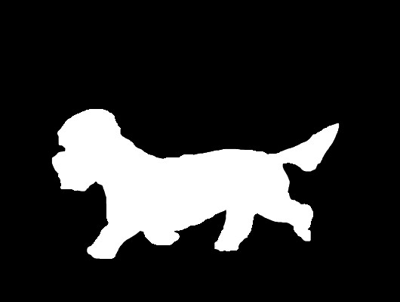

In [ ]:
mask

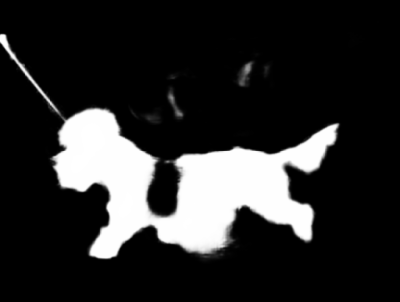

In [ ]:
alpha

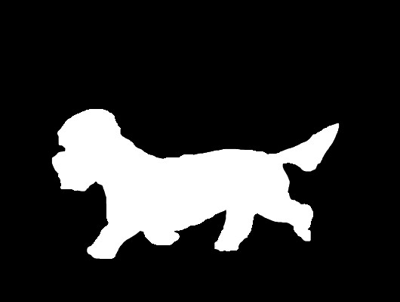

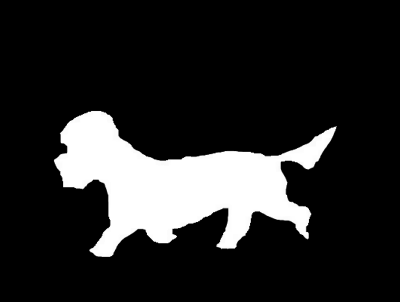

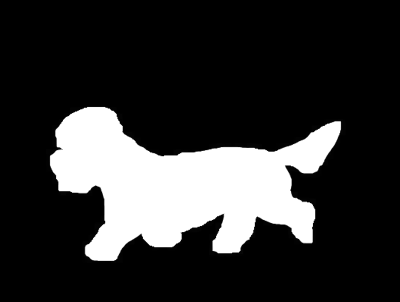

ValueError: ignored

In [ ]:
kernel = np.ones((5,5), np.uint8)
img = cv2.imread(url_mask)


# The first parameter is the original image,
# kernel is the matrix with which image is 
# convolved and third parameter is the number 
# of iterations, which will determine how much 
# you want to erode/dilate a given image. 
img_erosion = cv2.erode(img[:, :, 0], kernel, iterations=1)
img_dilation = cv2.dilate(img, kernel, iterations=1)
  
cv2_imshow(img)
cv2_imshow(img_erosion)
cv2_imshow(img_dilation)
trimap = img_dilation - img_erosion
cv2_imshow(trimap)

In [ ]:
if len(img.shape) == 3:
  print(img.mean(axis=2))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
img.mean(axis=2).shape

(302, 400)

In [ ]:
trimap.sum()

4073364

In [ ]:
trimap.shape

(302, 400, 3)

In [ ]:
trimap[:, :, 0].sum()

1357788

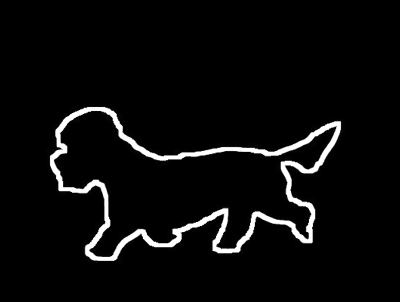

In [ ]:
cv2_imshow(img_dilation - img_erosion)

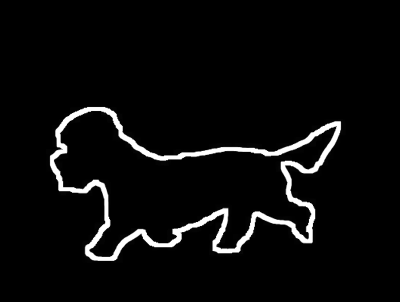